In [1]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import sklearn
import nltk

In [2]:
vocab_size = 18000
embedding_dim = 128
max_length = 12
filters = 250
kernel_size = 3
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
print(len(stopwords))
# Expected Output
# 153

153


In [4]:
data = pd.read_csv('Dataset.csv')

labels = list(pd.Series(data['category']).str.lower())
headlines = list(pd.Series(data['headline']).str.lower())

for i in range(0,len(headlines)):
    headline = headlines[i]
    for word in stopwords:
        token = " " + word + " "
        headline = headline.replace(token, " ")
    no_punct = ''
    for char in headline:
        if char not in punctuations:
            no_punct = no_punct + char
    headlines[i] = no_punct
print(len(labels))
print(len(headlines))
#print(headlines[0:100])

2496
2496


In [5]:
print(set(labels))

{'business', 'entertainment', 'sports', 'medical', 'tech'}


In [6]:
# train_headlines, validation_headlines, train_labels, validation_labels = train_test_split(headlines, labels, test_size=0.2)
train_size = int(training_portion*len(headlines))
train_headlines = headlines[:train_size]
train_labels = labels[:train_size]
validation_headlines = headlines[train_size:]
validation_labels = labels[train_size:]
print(len(train_headlines))
print(len(train_labels))
print(len(validation_headlines))
print(len(validation_labels))



1996
1996
500
500


In [7]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_headlines)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_headlines)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(word_index))
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

23065
143
12
119
12


In [8]:
validation_sequences = tokenizer.texts_to_sequences(validation_headlines)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

500
(500, 12)


In [9]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

padded_validation_label_seq = pad_sequences(validation_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)
train_lables_padded = pad_sequences(training_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)

category_word_index = label_tokenizer.word_index

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=3),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation = 'sigmoid'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.0008), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 128)           2304000   
_________________________________________________________________
dropout (Dropout)            (None, 12, 128)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 250)            96250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 250)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 48)                12048     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 2

In [11]:
num_epochs = 8
history = model.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)

Train on 1996 samples, validate on 500 samples
Epoch 1/8
1996/1996 - 3s - loss: 1.6597 - acc: 0.2450 - val_loss: 1.5863 - val_acc: 0.2940
Epoch 2/8
1996/1996 - 2s - loss: 1.3655 - acc: 0.6022 - val_loss: 1.1532 - val_acc: 0.6160
Epoch 3/8
1996/1996 - 3s - loss: 0.5566 - acc: 0.9254 - val_loss: 0.5916 - val_acc: 0.8340
Epoch 4/8
1996/1996 - 2s - loss: 0.1579 - acc: 0.9935 - val_loss: 0.4669 - val_acc: 0.8560
Epoch 5/8
1996/1996 - 3s - loss: 0.0725 - acc: 0.9985 - val_loss: 0.4301 - val_acc: 0.8680
Epoch 6/8
1996/1996 - 3s - loss: 0.0458 - acc: 0.9995 - val_loss: 0.4184 - val_acc: 0.8640
Epoch 7/8
1996/1996 - 2s - loss: 0.0331 - acc: 1.0000 - val_loss: 0.4124 - val_acc: 0.8640
Epoch 8/8
1996/1996 - 2s - loss: 0.0258 - acc: 1.0000 - val_loss: 0.4074 - val_acc: 0.8740


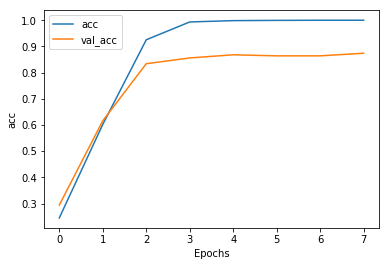

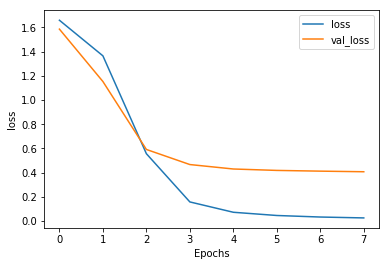

In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):

  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [15]:
def clean_data(sentence):
    stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    sentence = sentence.lower()
    for word in stopwords:
        token = " " + word + " "
        sentence = sentence.replace(token, " ")
    no_punct = ''
    for char in sentence:
        if char not in punctuations:
            no_punct = no_punct + char
    sentence = no_punct
    
    return sentence

In [17]:
test_headline_uncleaned = ['Maruti Suzukis profit to recover on demand for small cars']
test_headline_uncleaned.append('Federal Reserve Chair Warns Of Lasting Economic Damage From Pandemic')

test_headline_uncleaned.append('Facebook Buys Giphy to Integrate GIF Website With Instagram')
test_headline_uncleaned.append('Samsung Frame TV 2020 Lineup Set to Launch in India Next Week, Flipkart Teases Availability')

test_headline_uncleaned.append('Staggered start for 800m, skin-tight gloves: World Athletics studying possible safety options')
test_headline_uncleaned.append('Women T20 World Cup Final: Australian dominance continues as hosts beat India to lift fifth title')

test_headline_uncleaned.append('I am a Doctor, And I am Losing Patients To A Deadly Side Effect Of The Pandemic')
test_headline_uncleaned.append('9 causes of a stuffy nose and a headache')

test_headline_uncleaned.append('Miley cirus performs the climb during virtual graduation')
test_headline_uncleaned.append('See Every Star at the 2020 Nickelodeon Kids Choice Awards: Celebrate Together Show')

test_headlines = list()

for line in test_headline_uncleaned:
    test_headlines.append(clean_data(line))

test_headlines_sequence = tokenizer.texts_to_sequences(test_headlines)
test_headlines_padded = pad_sequences(test_headlines_sequence, padding = padding_type, maxlen=max_length, truncating=trunc_type)

In [18]:
prediction = model.predict(test_headlines_padded)
for i in prediction:
    x = (np.where(i == np.amax(i)))[0]
    for a in category_word_index:
        if category_word_index[a] == x:
            print('',a)

 medical
 business
 medical
 tech
 sports
 sports
 medical
 medical
 entertainment
 entertainment
